      index             r     l             t
0         0  8.444400e+05  1001     15.439719
1         1  9.537974e+05  1001     30.272268
2         2  4.263463e+05   490     37.545909
3         3  5.718559e+06  1001     52.216308
4         4  2.526085e+06  1001     70.614112
...     ...           ...   ...           ...
7870   7870  1.429931e+21    39  18801.306822
7871   7871  2.394333e+23    54  18802.508923
7872   7872  5.572505e+12    68  18803.857157
7873   7873  1.856704e+19    42  18804.976182
7874   7874  2.842182e+14    99  18806.659724

[7875 rows x 4 columns]


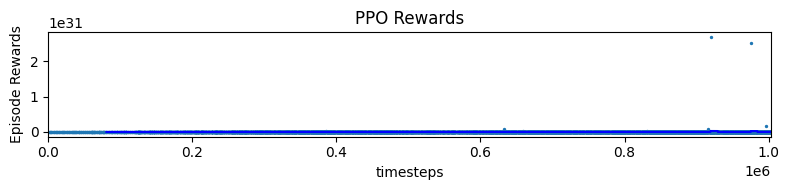

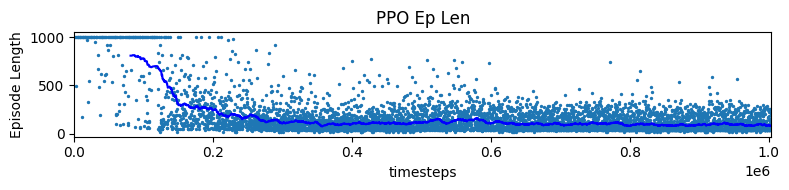

c:\Users\Pablo\Desktop\Code_vic\legged_robots\Project-2-Legged-Robot\.conda\Lib\site-packages\gym\spaces\box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
c:\Users\Pablo\Desktop\Code_vic\legged_robots\Project-2-Legged-Robot\.conda\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Box([-1.01 -1.01 -1.01 -1.01 0.49 -0.01 -0.01 -0.01 -0.01 -0.01 -0.01 -0.01 -0.01 -0.01 -0.01 -0.01 -0.01 -0.01 -0.01 -0.01 -0.01 -0.01 -30 -30 -30 -30 -0.01 -0.01 -0.01 -0.01], [1.01 1.01 1.01 1.01 5.01 0.51 0.51 1.01 1.01 1.01 1.01 1.01 1.01 1.01 1.01 1.01 1.01 1.01 6.29 6.29 6.29 6.29 30 30 30 30 31.4 31.4 31.4 31.4], (30,), float32)
(30,)
Box([-1.01 -1.01 -1.01 -1.01 0.49 -0.01 -0.01 -0.01 -0.01 -0.01 -0.01 -0.01 -0.01 -0.01 -0.01 -0.01 -0.01 -0.01 -0.01 -0.01 -0.01 -0.01 -30 -30 -30 -30 -0.01 -0.01 -0.01 -0.01], [1.01 1.01 1.01 1.01 5.01 0.51 0.51 1.01 1.01 1.01 1.01 1.01 1.01 1.01 1.01 1.01 1.01 1.01 6.29 6.29 6.29 6.29 30 30 30 30 31.4 31.4 31.4 31.4], (30,), float32)
(30,)

Loaded model ./logs/intermediate_models/121623233424\rl_model.zip 

episode_reward [5.36e+18]
Final base position (0.0020489119609380714, -0.0064594363398959125, 0.22062472117085932)


error: Not connected to physics server.

In [1]:
import os, sys
import gym
import numpy as np
import time
import matplotlib
import matplotlib.pyplot as plt
from sys import platform
# may be helpful depending on your system
# if platform =="darwin": # mac
#   import PyQt5
#   matplotlib.use("Qt5Agg")
# else: # linux
#   matplotlib.use('TkAgg')

# stable-baselines3
from stable_baselines3.common.monitor import load_results 
from stable_baselines3.common.vec_env import VecNormalize
from stable_baselines3 import PPO, SAC
# from stable_baselines3.common.cmd_util import make_vec_env
from stable_baselines3.common.env_util import make_vec_env # fix for newer versions of stable-baselines3

from env.quadruped_gym_env import QuadrupedGymEnv
# utils
from utils.utils import plot_results
from utils.file_utils import get_latest_model, load_all_results


LEARNING_ALG = "PPO"
interm_dir = "./logs/intermediate_models/"
# path to saved models, i.e. interm_dir + '121321105810'
# ./logs/intermediate_models/121623232427/
log_dir = interm_dir + '121623233424'


# initialize env configs (render at test time)
# check ideal conditions, as well as robustness to UNSEEN noise during training
env_config = {}
env_configs = {"motor_control_mode":"CARTESIAN_PD", #CPG, PD, CARTESIAN_PD
               "task_env": "LR_COURSE_TASK", #  "LR_COURSE_TASK", -> Controls the cost function
               "observation_space_mode": "LR_COURSE_OBS"} #Controls the observation space
env_config['render'] = True
env_config['record_video'] = False
env_config['add_noise'] = False 
env_config['competition_env'] = True

# get latest model and normalization stats, and plot 
stats_path = os.path.join(log_dir, "vec_normalize.pkl")
model_name = get_latest_model(log_dir)
monitor_results = load_results(log_dir)
print(monitor_results)
plot_results([log_dir] , 10e10, 'timesteps', LEARNING_ALG + ' ')
plt.show() 

# reconstruct env 
env = lambda: QuadrupedGymEnv(**env_config)
env = make_vec_env(env, n_envs=1)
env = VecNormalize.load(stats_path, env)
env.training = False    # do not update stats at test time
env.norm_reward = False # reward normalization is not needed at test time

# load model
if LEARNING_ALG == "PPO":
    model = PPO.load(model_name, env)
elif LEARNING_ALG == "SAC":
    model = SAC.load(model_name, env)
print("\nLoaded model", model_name, "\n")

obs = env.reset()
episode_reward = 0

# [TODO] initialize arrays to save data from simulation 
#

for i in range(2000):
    action, _states = model.predict(obs,deterministic=False) # sample at test time? ([TODO]: test)
    obs, rewards, dones, info = env.step(action)
    episode_reward += rewards
    if dones:
        print('episode_reward', episode_reward)
        print('Final base position', info[0]['base_pos'])
        episode_reward = 0

    # [TODO] save data from current robot states for plots 
    # To get base position, for example: env.envs[0].env.robot.GetBasePosition() 
    #
    
# [TODO] make plots: